In [2]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# __CNN trained on MNIS__ Federated Learning - Fedavg - _testing different dataset partitions_

## Federated Learning on MNIST: Exploring Data Partition Strategies

> **Overview:**  
> This notebook demonstrates federated learning using PySyft and PyTorch.  
> The model—a CNN—is trained on the MNIST dataset, which is partitioned into different subsets.  
> Each subset is sent to a different worker for training. Workers send their model updates back to the server, which aggregates them to update the global model.

---
### **Why MNIST and a Small CNN?**

For this first experiment, I **chose the MNIST dataset and a lightweight CNN model** as a proof of concept.  
This combination allows for **short training times on a local machine**, making it ideal for rapid prototyping and exploring federated learning concepts without heavy computational requirements.

---

### **Objective**

We investigate how different dataset partitioning strategies affect model performance.  
The goal is to understand the impact of partitioning on training dynamics and final accuracy.

---

### **Partitioning Strategies**

- **IID (Independent and Identically Distributed):**  
  Each worker receives a random, balanced subset of the dataset.

- **Non-IID:**  
  Each worker receives a different subset, with some workers getting more samples of certain classes than others.

---

### **Experiment Plan**

We will compare the following partitioning strategies:

| Strategy | Description |
|----------|-------------|
| **IID** | Random, balanced distribution across workers |
| **Non-IID** | Skewed distribution, controlled by Dirichlet α parameter |

---

> **Key Question:**  
> _How does increasing data heterogeneity (lower α) affect federated learning performance?_

### IID split

In [4]:
# Cell 2: Define the model class (must match your training code)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10, in_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7 * 7 * 128, 256), nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.classifier(self.features(x))



In [5]:
# Cell 3: Load the MNIST test set (as 3-channel images)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)



In [4]:
# Cell 4: Load the trained model weights
model_path = "TrainedModels/cnn_mnist_fedavg_iid_rounds5_global.pt"  # Adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=10, in_channels=3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()


C:\Users\francesco\AppData\Local\Temp\ipykernel_9988\941415922.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [5]:
# Cell 2: Evaluate the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on MNIST test set: {100 * correct / total:.2f}%")


Accuracy on MNIST test set: 99.22%


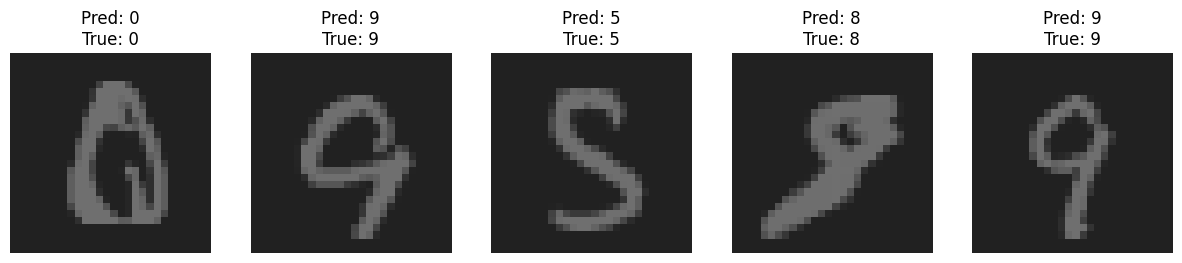

In [6]:
# Cell 6: Show some predictions
def imshow(img):
    img = img * 0.3081 + 0.1307  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.axis('off')

# Show 5 random test images with predictions
import random
indices = random.sample(range(len(testset)), 5)
plt.figure(figsize=(15,3))
for i, idx in enumerate(indices):
    img, label = testset[idx]
    plt.subplot(1, 5, i+1)
    imshow(img)
    pred = all_preds[idx]
    plt.title(f"Pred: {pred}\nTrue: {label}", fontsize=12)
plt.show()

### No IID split, Dirichlet alpha = 0.5

In [7]:
# Cell 1: Load the trained model weights
model_path = "TrainedModels/cnn_mnist_fedavg_alpha05_rounds5_global.pt"  # Adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=10, in_channels=3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

C:\Users\francesco\AppData\Local\Temp\ipykernel_9988\2553426214.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [8]:
# Cell 2: Evaluate the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on MNIST test set: {100 * correct / total:.2f}%")


Accuracy on MNIST test set: 98.82%


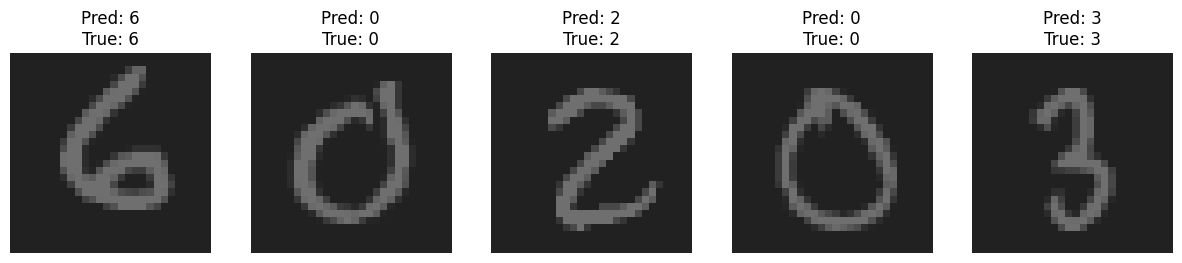

In [9]:
# Cell 3: Show some predictions
def imshow(img):
    img = img * 0.3081 + 0.1307  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.axis('off')

# Show 5 random test images with predictions
import random
indices = random.sample(range(len(testset)), 5)
plt.figure(figsize=(15,3))
for i, idx in enumerate(indices):
    img, label = testset[idx]
    plt.subplot(1, 5, i+1)
    imshow(img)
    pred = all_preds[idx]
    plt.title(f"Pred: {pred}\nTrue: {label}", fontsize=12)
plt.show()

### No IID split, Dirichlet alpha = 0.2

In [10]:
# Cell 1: Load the trained model weights
model_path = "TrainedModels/cnn_mnist_fedavg_alpha02_rounds5_global.pt"  # Adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=10, in_channels=3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

C:\Users\francesco\AppData\Local\Temp\ipykernel_9988\3958925051.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [11]:
# Cell 2: Evaluate the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on MNIST test set: {100 * correct / total:.2f}%")

Accuracy on MNIST test set: 97.41%


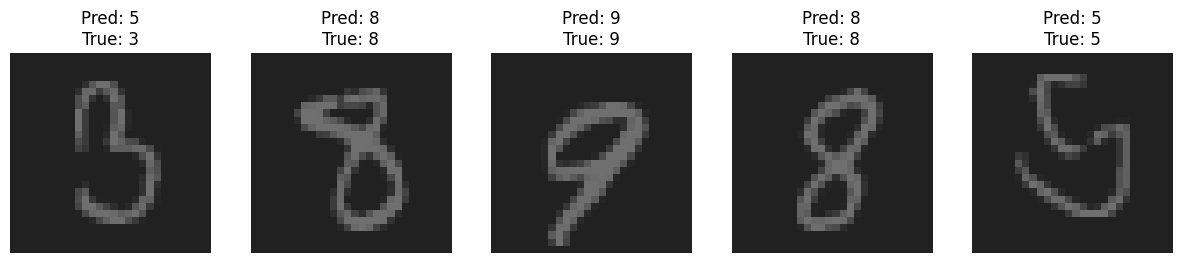

In [12]:
# Cell 3: Show some predictions
def imshow(img):
    img = img * 0.3081 + 0.1307  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.axis('off')

# Show 5 random test images with predictions
import random
indices = random.sample(range(len(testset)), 5)
plt.figure(figsize=(15,3))
for i, idx in enumerate(indices):
    img, label = testset[idx]
    plt.subplot(1, 5, i+1)
    imshow(img)
    pred = all_preds[idx]
    plt.title(f"Pred: {pred}\nTrue: {label}", fontsize=12)
plt.show()

### No IID split, Dirichlet alpha = 0.05

In [13]:
# Cell 1: Load the trained model weights
model_path = "TrainedModels/cnn_mnist_fedavg_alpha005_rounds5_global.pt"  # Adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=10, in_channels=3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

C:\Users\francesco\AppData\Local\Temp\ipykernel_9988\2063368363.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [14]:
# Cell 2: Evaluate the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on MNIST test set: {100 * correct / total:.2f}%")

Accuracy on MNIST test set: 95.16%


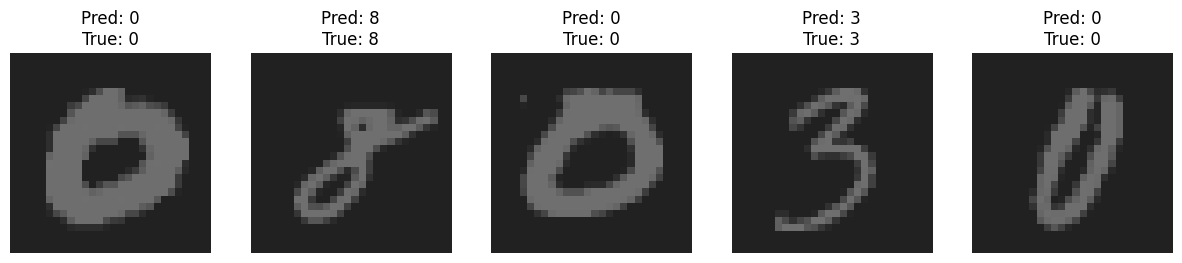

In [15]:
# Cell 3: Show some predictions
def imshow(img):
    img = img * 0.3081 + 0.1307  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.axis('off')

# Show 5 random test images with predictions
import random
indices = random.sample(range(len(testset)), 5)
plt.figure(figsize=(15,3))
for i, idx in enumerate(indices):
    img, label = testset[idx]
    plt.subplot(1, 5, i+1)
    imshow(img)
    pred = all_preds[idx]
    plt.title(f"Pred: {pred}\nTrue: {label}", fontsize=12)
plt.show()

### No IID split, Dirichlet alpha = 0.02

In [25]:
# Cell 1: Load the trained model weights
model_path = "TrainedModels/cnn_mnist_fedavg_alpha002_rounds5_global.pt"  # Adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=10, in_channels=3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [26]:
# Cell 2: Evaluate the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on MNIST test set: {100 * correct / total:.2f}%")

Accuracy on MNIST test set: 71.48%


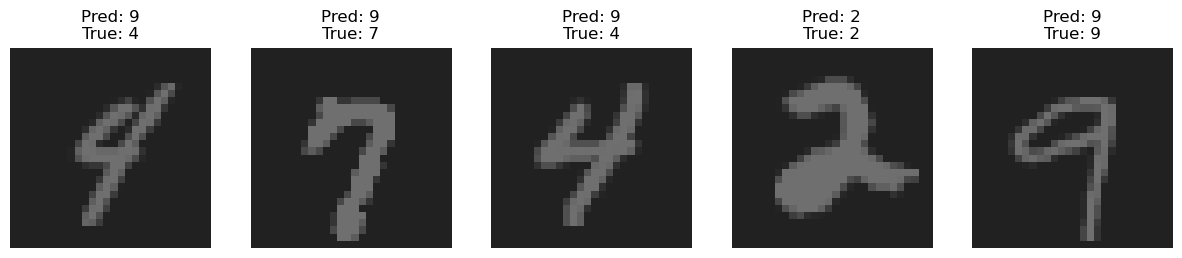

In [27]:
# Cell 3: Show some predictions
def imshow(img):
    img = img * 0.3081 + 0.1307  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.axis('off')

# Show 5 random test images with predictions
import random
indices = random.sample(range(len(testset)), 5)
plt.figure(figsize=(15,3))
for i, idx in enumerate(indices):
    img, label = testset[idx]
    plt.subplot(1, 5, i+1)
    imshow(img)
    pred = all_preds[idx]
    plt.title(f"Pred: {pred}\nTrue: {label}", fontsize=12)
plt.show()

### No IID split, Dirichlet alpha = 0.015

In [31]:
# Cell 1: Load the trained model weights
model_path = "TrainedModels/cnn_mnist_fedavg_alpha0015_rounds5_global.pt"  # Adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=10, in_channels=3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [32]:
# Cell 2: Evaluate the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on MNIST test set: {100 * correct / total:.2f}%")

Accuracy on MNIST test set: 61.88%


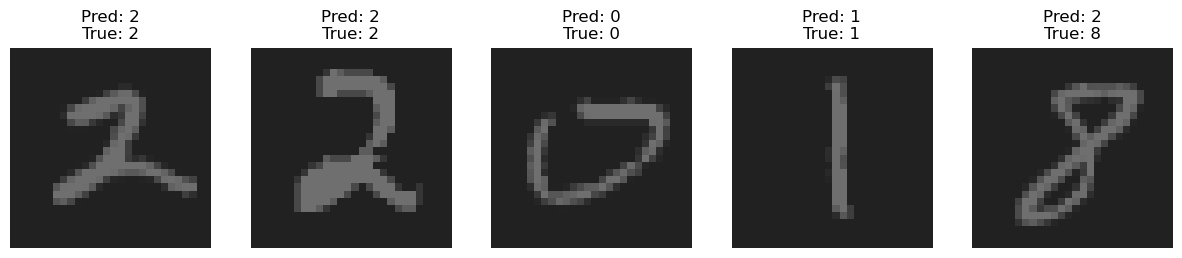

In [33]:
# Cell 3: Show some predictions
def imshow(img):
    img = img * 0.3081 + 0.1307  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.axis('off')

# Show 5 random test images with predictions
import random
indices = random.sample(range(len(testset)), 5)
plt.figure(figsize=(15,3))
for i, idx in enumerate(indices):
    img, label = testset[idx]
    plt.subplot(1, 5, i+1)
    imshow(img)
    pred = all_preds[idx]
    plt.title(f"Pred: {pred}\nTrue: {label}", fontsize=12)
plt.show()

### No IID split, Dirichlet alpha = 0.01

In [19]:
# Cell 1: Load the trained model weights
model_path = "TrainedModels/cnn_mnist_fedavg_alpha001_rounds5_global.pt"  # Adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=10, in_channels=3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [20]:
# Cell 2: Evaluate the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on MNIST test set: {100 * correct / total:.2f}%")

Accuracy on MNIST test set: 41.38%


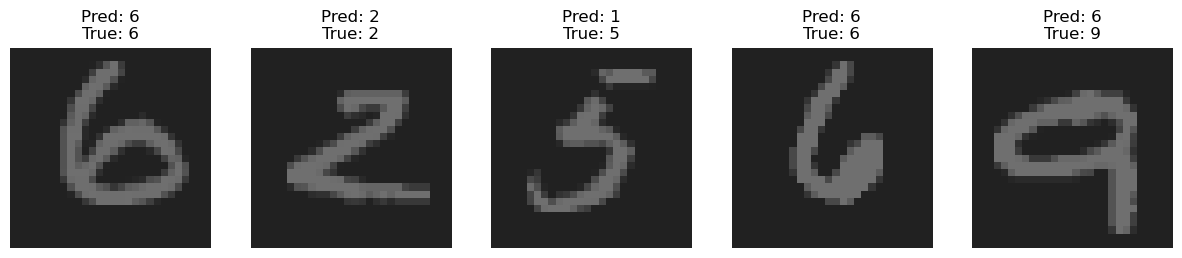

In [21]:
# Cell 3: Show some predictions
def imshow(img):
    img = img * 0.3081 + 0.1307  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.axis('off')

# Show 5 random test images with predictions
import random
indices = random.sample(range(len(testset)), 5)
plt.figure(figsize=(15,3))
for i, idx in enumerate(indices):
    img, label = testset[idx]
    plt.subplot(1, 5, i+1)
    imshow(img)
    pred = all_preds[idx]
    plt.title(f"Pred: {pred}\nTrue: {label}", fontsize=12)
plt.show()

### Extreme No IID split, Dirichlet alpha = 0.005

In [6]:
# Cell 1: Load the trained model weights
model_path = "TrainedModels/cnn_mnist_fedavg_alpha0005_rounds5_global.pt"  # Adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=10, in_channels=3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [7]:
# Cell 2: Evaluate the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on MNIST test set: {100 * correct / total:.2f}%")

Accuracy on MNIST test set: 30.95%


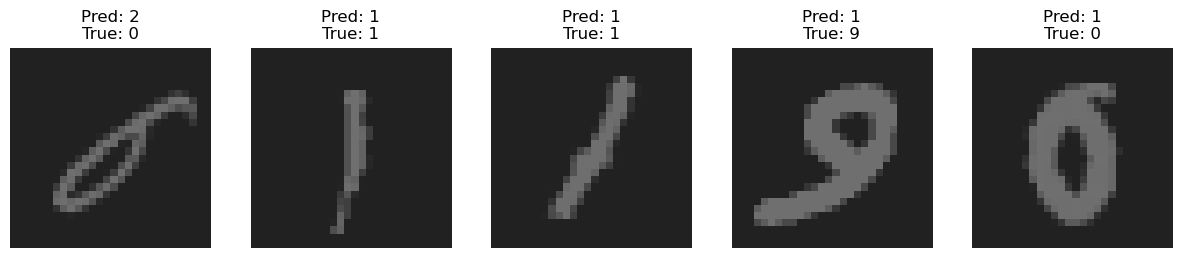

In [8]:
# Cell 3: Show some predictions
def imshow(img):
    img = img * 0.3081 + 0.1307  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.axis('off')

# Show 5 random test images with predictions
import random
indices = random.sample(range(len(testset)), 5)
plt.figure(figsize=(15,3))
for i, idx in enumerate(indices):
    img, label = testset[idx]
    plt.subplot(1, 5, i+1)
    imshow(img)
    pred = all_preds[idx]
    plt.title(f"Pred: {pred}\nTrue: {label}", fontsize=12)
plt.show()

### Extreme No IID split, Dirichlet alpha = 0.001

In [16]:
# Cell 1: Load the trained model weights
model_path = "TrainedModels/cnn_mnist_fedavg_alpha0001_rounds5_global.pt"  # Adjust if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=10, in_channels=3).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

C:\Users\francesco\AppData\Local\Temp\ipykernel_9988\2773830967.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
# Cell 2: Evaluate the model
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on MNIST test set: {100 * correct / total:.2f}%")

Accuracy on MNIST test set: 11.35%


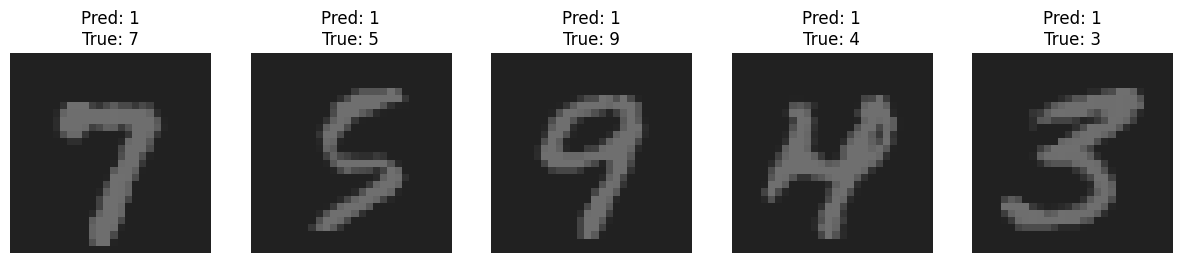

In [18]:
# Cell 3: Show some predictions
def imshow(img):
    img = img * 0.3081 + 0.1307  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.axis('off')

# Show 5 random test images with predictions
import random
indices = random.sample(range(len(testset)), 5)
plt.figure(figsize=(15,3))
for i, idx in enumerate(indices):
    img, label = testset[idx]
    plt.subplot(1, 5, i+1)
    imshow(img)
    pred = all_preds[idx]
    plt.title(f"Pred: {pred}\nTrue: {label}", fontsize=12)
plt.show()

### Random model - show how pourly low alphas predict

In [49]:
# Cell: Evaluate a random model (no training) on MNIST test set
import torch
import numpy as np

# Use the same testloader and device as before
num_classes = 10
correct = 0
total = 0

np.random.seed(42)
with torch.no_grad():
    for images, labels in testloader:
        batch_size = labels.size(0)
        random_preds = torch.from_numpy(np.random.randint(0, num_classes, size=batch_size)).to(device)
        correct += (random_preds == labels).sum().item()
        total += batch_size

random_accuracy = 100 * correct / total
print(f"Random model accuracy on MNIST test set: {random_accuracy:.2f}%")

Random model accuracy on MNIST test set: 10.22%


---

### Visualization of the results

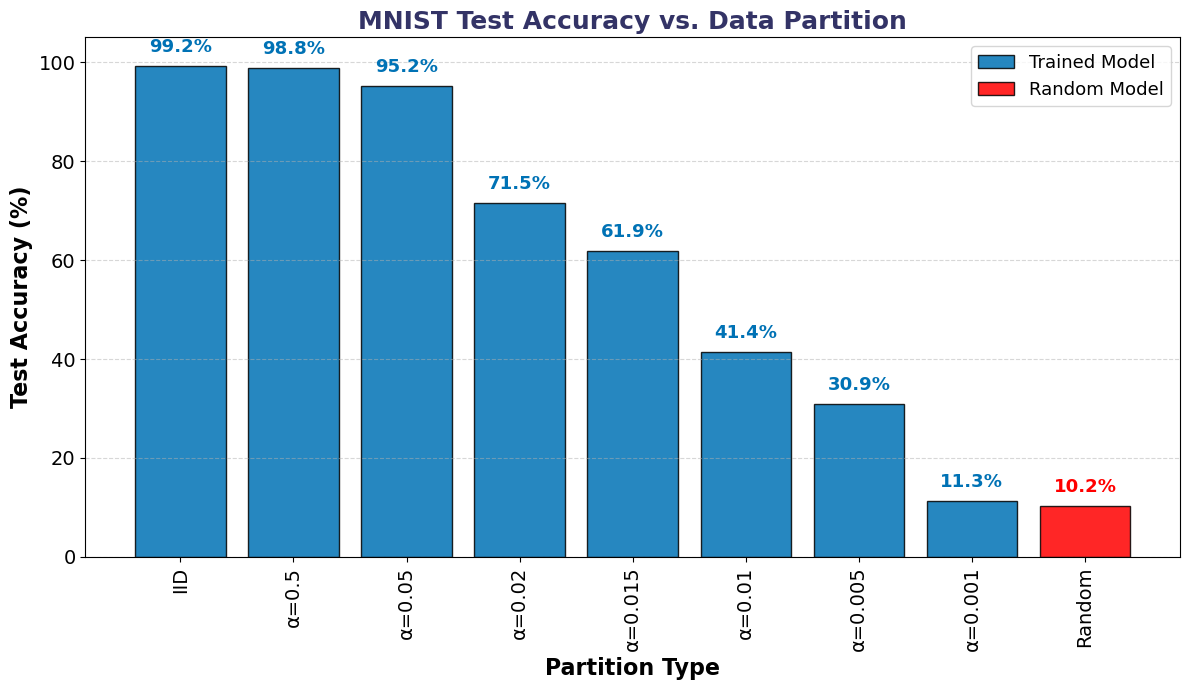

In [50]:
import matplotlib.pyplot as plt

partition_types = ['IID', 'α=0.5', 'α=0.05', 'α=0.02', 'α=0.015', 'α=0.01', 'α=0.005', 'α=0.001', 'Random']
accuracies = [99.21, 98.82, 95.16, 71.48, 61.88, 41.38, 30.95, 11.35, random_accuracy]  # Add random_accuracy at the end

plt.figure(figsize=(12, 7))
bars = plt.bar(partition_types[:-1], accuracies[:-1], color='#0072B5', edgecolor='black', alpha=0.85, label='Trained Model')
bar_random = plt.bar(partition_types[-1], accuracies[-1], color='red', edgecolor='black', alpha=0.85, label='Random Model')

plt.ylabel('Test Accuracy (%)', fontsize=16, fontweight='bold')
plt.xlabel('Partition Type', fontsize=16, fontweight='bold')
plt.title('MNIST Test Accuracy vs. Data Partition', fontsize=18, fontweight='bold', color='#333366')
plt.ylim(0, 105)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate each bar with its value
for bar, acc in zip(bars, accuracies[:-1]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f"{acc:.1f}%", 
             ha='center', va='bottom', fontsize=13, fontweight='bold', color='#0072B5')
for bar, acc in zip(bar_random, [accuracies[-1]]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f"{acc:.1f}%", 
             ha='center', va='bottom', fontsize=13, fontweight='bold', color='red')

plt.tight_layout()
plt.legend(fontsize=13)
plt.show()

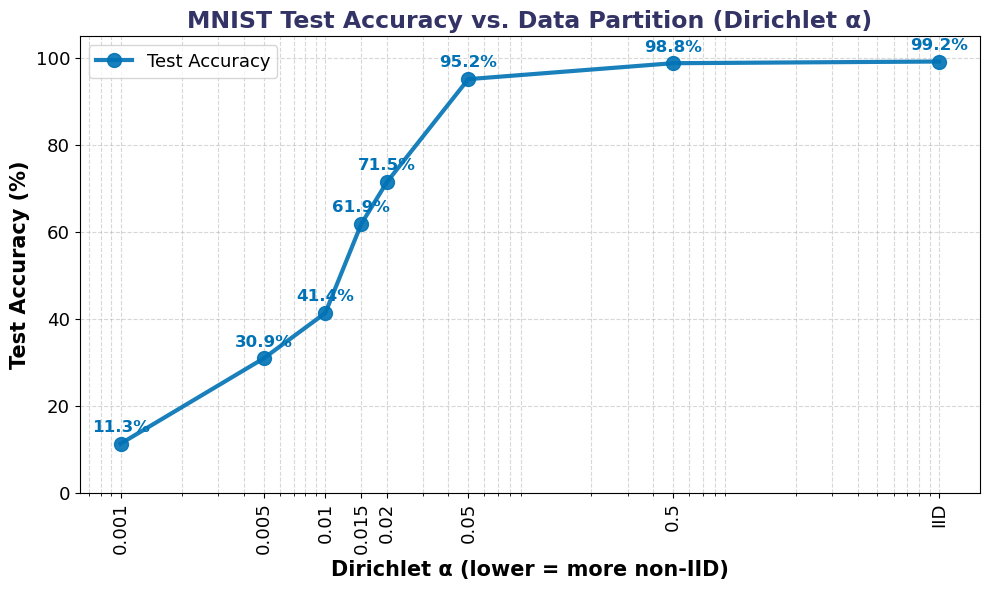

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Dirichlet alpha values and corresponding accuracies
alphas = [None, 0.5, 0.05, 0.02,0.015, 0.01,  0.005, 0.001]
accuracies = [  # Fill in your results
    99.21, 98.82, 95.16, 71.48 ,61.88,41.38, 30.95, 11.35
]

# For plotting, replace None (IID) with a high value (e.g., 10) for log scale
plot_alphas = [10 if a is None else a for a in alphas]
labels = ['IID', '0.5', '0.05', '0.02','0.015', '0.01', '0.005', '0.001']

plt.figure(figsize=(10, 6))
plt.plot(plot_alphas, accuracies, marker='o', markersize=10, linestyle='-', linewidth=3, color='#0072B5', alpha=0.9, label='Test Accuracy')
plt.xscale('log')
plt.xticks(plot_alphas, labels, rotation=90, fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Dirichlet α (lower = more non-IID)', fontsize=15, fontweight='bold')
plt.ylabel('Test Accuracy (%)', fontsize=15, fontweight='bold')
plt.title('MNIST Test Accuracy vs. Data Partition (Dirichlet α)', fontsize=17, fontweight='bold', color='#333366')
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Annotate each point with its accuracy value
for x, y, label in zip(plot_alphas, accuracies, labels):
    plt.text(x, y + 2, f"{y:.1f}%", ha='center', va='bottom', fontsize=12, fontweight='bold', color='#0072B5')

plt.ylim(0, 105)
plt.tight_layout()
plt.legend(fontsize=13)
plt.show()

___
### Summary Table: Accuracy vs. Partition Type

| Partition Type    | Dirichlet α | Accuracy (%) | Notes                      |
| ----------------- | ----------- | ------------ | -------------------------- |
| IID               | –           | 99.21             | Balanced, fast convergence |
| Non-IID (mild)    | 0.5         | 98.82             | Some skew, moderate drop   |
| Non-IID (medium)  | 0.2         | 97.41             | More skew, slower training |
| Non-IID (strong)  | 0.05        | 95.16             | High skew, accuracy drops  |
| Non-IID (extreme) | 0.001       | 11.35             | Very high skew, unstable   |

---

### Expected Trends

* **IID**
  Highest accuracy, fastest convergence.

* **Decreasing α (increasing non-IID)**

  * Accuracy generally decreases.
  * Training becomes slower and less stable.
  * Greater risk of overfitting to dominant classes on each client.

* **Extreme non-IID (α = 0.001)**
  Model may fail to generalize; accuracy can drop sharply. Aproaches the preformance of a random model (10 classes - 10% of getting it right with random algorithm)
___


# __ResNet18 trained on CIFAR10__ Federated Learning - _testing different dataset partitions_

___note___: Keeping the rounds low for now. Will be increased in the future.

### IID split

In [20]:
# Cell 1: Define the model class (must match your training code)
from torchvision.models import resnet18

class ResNet18CIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [21]:
# Cell 2: Load the CIFAR-10 test set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified


In [22]:
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(torch.load("TrainedModels/resnet18_cifar10_fedavg_iid_rounds5_global.pt"))

C:\Users\francesco\AppData\Local\Temp\ipykernel_9988\3977169706.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("TrainedModels/resnet18_

<All keys matched successfully>

In [23]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on CIFAR-10 test set: {100 * correct / total:.2f}%")

Accuracy on CIFAR-10 test set: 39.49%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


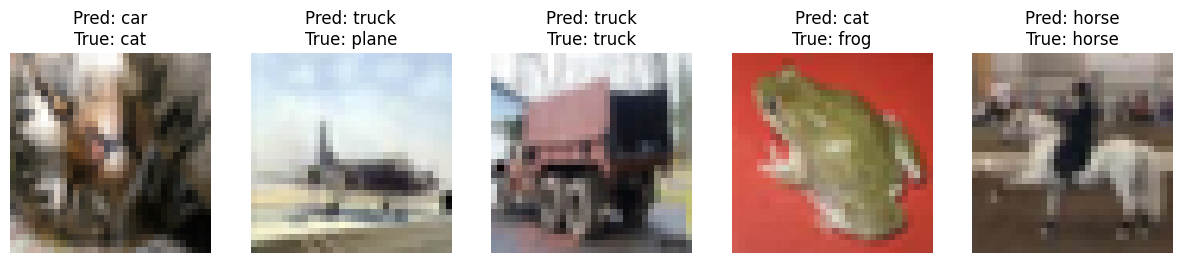

In [24]:
import matplotlib.pyplot as plt
import random
import numpy as np

# CIFAR-10 class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Pick 5 random indices
indices = random.sample(range(len(testset)), 5)
plt.figure(figsize=(15,3))
for i, idx in enumerate(indices):
    img, label = testset[idx]
    # Unnormalize for display
    img_disp = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
    npimg = img_disp.numpy()
    plt.subplot(1, 5, i+1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Predict
    model.eval()
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).argmax(1).item()
    plt.title(f"Pred: {classes[pred]}\nTrue: {classes[label]}", fontsize=12)
plt.show()